In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import math
from image import *

from plotting import *

np.random.seed(0)

In [2]:
%load_ext autoreload
%autoreload
%aimport image, plotting

In [12]:
# SIZE = 31
SIZE = 21
DATA_PATH = "data/{}x{}/seed0".format(SIZE, SIZE)
 
seeds = [0]
fname = [f"seed{i:d}/{t}_pt.csv" for i in seeds for t in "wg"]

correction_params = {"ptmean": False, "rotate": True, "transform_layers_together": True}
plot_params = {"log_color":True}

# Generate column headings and types for df loading
i32 = type(1)
f64 = type(0.1)
stype = type("string")

n_cols = [f"n{i}" for i in range(SIZE**2)]
q_cols = [f"q{i}" for i in range(SIZE**2)]
pixel_cols = n_cols + q_cols
column_heads = ["event", "jet", "type"] + pixel_cols
col_types = ([i32, i32, i32] + [f64] * (2 * SIZE * SIZE) + [f64]) # 2 int ids, a string type, 2 images and an extra ,
dtypes = {col:dtype for col, dtype in zip(column_heads + ["null"], col_types)}
converters = {"type": lambda letter: 1 if letter == "W" else 0}

In [13]:
def correct_series(series, **kwargs):
    ids, jet_type, images = extract_info(series)
    corrected = correct_image(images, **kwargs).flatten()
    corrected = corrected / corrected.sum()
    return np.concatenate((ids, jet_type, corrected.flatten()), axis=None)
    
def extract_info(series):
    array = series.values
    ids = array[:2]
    jet_type = array[2]
    images = array[3:].astype(f64)
    try:
        return ids, jet_type, images.reshape((SIZE,SIZE,2))
    except:
        print(series)
        

In [14]:
data = (pd.concat([pd.read_csv(f"{DATA_PATH}/{name}", header=None, converters=converters, names=column_heads+["null"], dtype=dtypes, usecols=range(3+2*SIZE**2))[column_heads]
                    for name in fnames], ignore_index=True, axis=0)
        .dropna()
        .apply(correct_series, axis=1, result_type="broadcast", **correction_params)
        .sample(frac=1)
        )

C:\Users\Lewis\Anaconda2\envs\DataScience3.6\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Both a converter and dtype were specified for column type - only the converter will be used
  


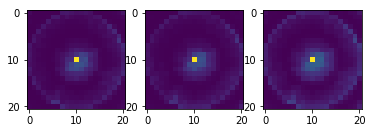

In [15]:
w_et = data[data["type"] == 1][pixel_cols]
show_images([w_et.mean().values.reshape((SIZE,SIZE,2))[:,:,0].T,
             w_et.mean().values.reshape((SIZE,SIZE,2))[:,:,1].T,
             w_et.mean().values.reshape((SIZE,SIZE,2)).sum(axis=2).T],
             **plot_params)

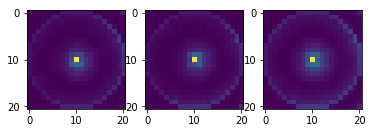

In [16]:
g_et = data[data["type"] == 0][pixel_cols]
show_images([g_et.mean().values.reshape((SIZE,SIZE,2))[:,:,0].T,
             g_et.mean().values.reshape((SIZE,SIZE,2))[:,:,1].T,
             g_et.mean().values.reshape((SIZE,SIZE,2)).sum(axis=2).T],
             **plot_params)

In [8]:
print("Gluon: {}; W: {};".format(g_et.shape[0], w_et.shape[0]))

Gluon: 60732; W: 121648;


In [9]:
import tensorflow as tf

def make_input_func(df, epochs=None):
    return tf.estimator.inputs.numpy_input_fn(
        x = {"n":df[n_cols].values.astype(f64), "q":df[q_cols].values.astype(f64)},
        y = df["type"].values,
        batch_size = 128,
        num_epochs = epochs,
        queue_capacity = 1000,
        shuffle=False
    )
def create_feature_cols():
    return [tf.feature_column.numeric_column("n", shape=(SIZE,SIZE)),
            tf.feature_column.numeric_column("q", shape=(SIZE,SIZE))]

def evaluate(clf, df, train_frac=0.8, steps=10000, epochs=1000):
    # Split the data
    mask = np.random.rand(len(data)) < train_frac
    train_df = data[mask]
    test_df = data[~mask]
    # Train on training set and make predictions about test set
    clf.train(input_fn=make_input_func(train_df, epochs=epochs), steps=steps)
    y_true = test_df['type'].values
    y_probs = np.asarray([result['probabilities'] for result in clf.predict(make_input_func(test_df, epochs=1))])
    y_scores = y_probs[:,1]
    y_pred = y_scores > 0.5 # Binary so a prob > 0.5 in the 1 column correctly reads as 1
    return y_scores, y_pred, y_true

In [10]:
clf = tf.estimator.DNNClassifier(
            feature_columns=create_feature_cols(),
            hidden_units=[1024,256,64])

y_scores, y_pred, y_true = evaluate(clf, data)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Lewis\\AppData\\Local\\Temp\\tmpiasyr69i', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E28A1A55C0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for up

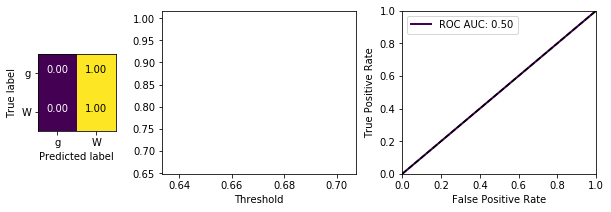

In [11]:
plot_evaluations(y_scores, y_pred, y_true)